<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_3_Sunspots_CNN_RNN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Predicting Sunspots with Neural Networks

At this point in the course, you should be able to explore different network architectures for forecasting. In the previous weeks, you've used DNNs, RNNs, and CNNs to build these different models. In the final practice lab for this course, you'll try one more configuration and that is a combination of all these types of networks: the data windows will pass through a convolution, followed by stacked LSTMs, followed by stacked dense layers. See if this improves results or you can just opt for simpler models.

In [ ]:
# Install this package to use Colab's GPU for training
# !apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

## Utilities

In [2]:
def plot_series(
    x,
    y,
    format="-",
    start=0,
    end=None,
    title=None,
    xlabel=None,
    ylabel=None,
    legend=None,
):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

        # Loop over the y elements
        for y_curr in y:

            # Plot the x and current y values
            plt.plot(x[start:end], y_curr[start:end], format)

    else:
        # Plot the x and y values
        plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
        plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

In [ ]:
# Download the Dataset
# !wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

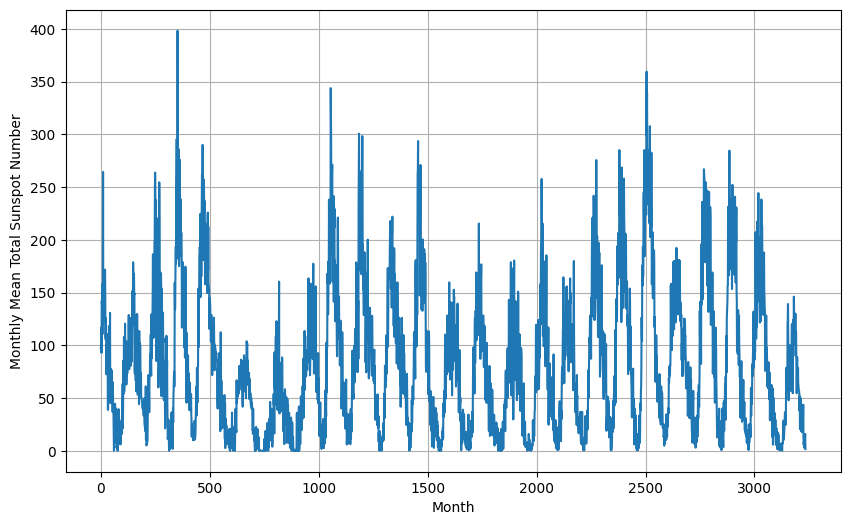

In [3]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open("./data/Sunspots.csv") as csvfile:

    # Initialize reader
    reader = csv.reader(csvfile, delimiter=",")

    # Skip the first line
    next(reader)

    # Append row and sunspot number to lists
    for row in reader:
        time_step.append(int(row[0]))
        sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel="Month", ylabel="Monthly Mean Total Sunspot Number")

## Split the Dataset

In [4]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
y_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
y_valid = series[split_time:]

## Prepare Features and Labels

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

As mentioned in the lectures, if your results don't good, you can try tweaking the parameters here and see if the model will learn better.

In [6]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(y_train, window_size, batch_size, shuffle_buffer_size)

Metal device set to: Apple M1


2022-12-02 10:56:15.136608: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-02 10:56:15.137300: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Print properties of a single batch
for windows in train_set.take(1):
    print(f"data type: {type(windows)}")
    print(f"number of elements in the tuple: {len(windows)}")
    print(f"shape of first element: {windows[0].shape}")
    print(f"shape of second element: {windows[1].shape}")
    print(windows)

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 30)
shape of second element: (32,)
(<tf.Tensor: shape=(32, 30), dtype=float64, numpy=
array([[ 52.6,  43.4,  52.8,  18.3,  43. ,  54.7,  34.6,   6.3,  33.7,
         32.6,  58.3,  52.5,  43.5,  24.8,  45.9,  41.8,  50.9,  32. ,
         44.4,   7.5,  32.3,  48.9,  17.9,  34.1,  43.1,   8.6,  14.9,
         13.2,  15.1,  36. ],
       [ 94.1,  87. , 120.1, 141. , 177.3, 110.5, 108.4,  73.2,  84.6,
        103.4, 140.6, 135.4, 136.8,  79. ,  83.6, 155.8,  90.9,  63.4,
         55.6,  75.4,  91.6,  63.2,  77.1,  72.5,  48.3,  51.5,  92.6,
         91.9,  44.8,  68.9],
       [ 20.3,   7.3,   0. ,  19.3,  18.7,   6.5,  20.5,   1.7,  13.2,
          5.3,   9.3,  25.2,  13.2,  36.2,  19.3,  10.5,  36.3,  18.7,
         31.7,   1.7,  40.3,  26.7,  50. ,  58.3,  66.7,  75. ,  60.8,
         65. , 159.2, 133.8],
       [ 31.3,  20.5,  13.7,  40.2,  22. ,   7. ,  17. ,  18.7,  11.3,
         10.8,   0. ,  

2022-12-02 10:57:40.636878: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## Build the Model

You've seen these layers before and here is how it's looks like when combined.

In [15]:
# Build the Model
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv1D(
            filters=64,
            kernel_size=3,
            strides=1,
            activation="relu",
            padding="causal",
            input_shape=[window_size, 1],  # or [None, 1]
        ),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 400),
    ]
)

# Print the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 30, 64)            256       
                                                                 
 lstm_8 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 30)                1950      
                                                                 
 dense_13 (Dense)            (None, 10)                310       
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
 lambda_4 (Lambda)           (None, 1)                

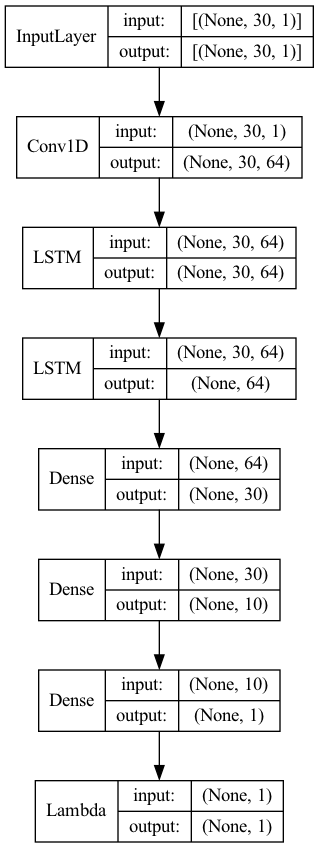

In [16]:
from keras_visualizer import visualizer
from IPython.display import Image

tf.keras.utils.plot_model(
    model, 
    show_shapes=True, 
    show_layer_names=False
)
# visualizer(model_tune, format='png')
# Image(filename='graph.png') 

## Tune the Learning Rate

As usual, you will want to pick an optimal learning rate.

In [17]:
# Get initial weights
init_weights = model.get_weights()

In [18]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose=2)

Epoch 1/100


2022-12-02 11:01:27.907524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:01:28.272007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:01:29.260300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:01:30.855623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:01:31.579621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 - 8s - loss: 112.9076 - lr: 1.0000e-08 - 8s/epoch - 82ms/step
Epoch 2/100
93/93 - 2s - loss: 61.2301 - lr: 1.1220e-08 - 2s/epoch - 20ms/step
Epoch 3/100
93/93 - 2s - loss: 51.4399 - lr: 1.2589e-08 - 2s/epoch - 20ms/step
Epoch 4/100
93/93 - 2s - loss: 47.4662 - lr: 1.4125e-08 - 2s/epoch - 20ms/step
Epoch 5/100
93/93 - 2s - loss: 44.5057 - lr: 1.5849e-08 - 2s/epoch - 20ms/step
Epoch 6/100
93/93 - 2s - loss: 41.9429 - lr: 1.7783e-08 - 2s/epoch - 20ms/step
Epoch 7/100
93/93 - 2s - loss: 39.8492 - lr: 1.9953e-08 - 2s/epoch - 20ms/step
Epoch 8/100
93/93 - 2s - loss: 38.1880 - lr: 2.2387e-08 - 2s/epoch - 20ms/step
Epoch 9/100
93/93 - 2s - loss: 36.7694 - lr: 2.5119e-08 - 2s/epoch - 20ms/step
Epoch 10/100
93/93 - 2s - loss: 35.5355 - lr: 2.8184e-08 - 2s/epoch - 20ms/step
Epoch 11/100
93/93 - 2s - loss: 34.4165 - lr: 3.1623e-08 - 2s/epoch - 20ms/step
Epoch 12/100
93/93 - 2s - loss: 33.3861 - lr: 3.5481e-08 - 2s/epoch - 20ms/step
Epoch 13/100
93/93 - 2s - loss: 32.3990 - lr: 3.9811e-08 - 2

(1e-08, 0.001, 0.0, 100.0)

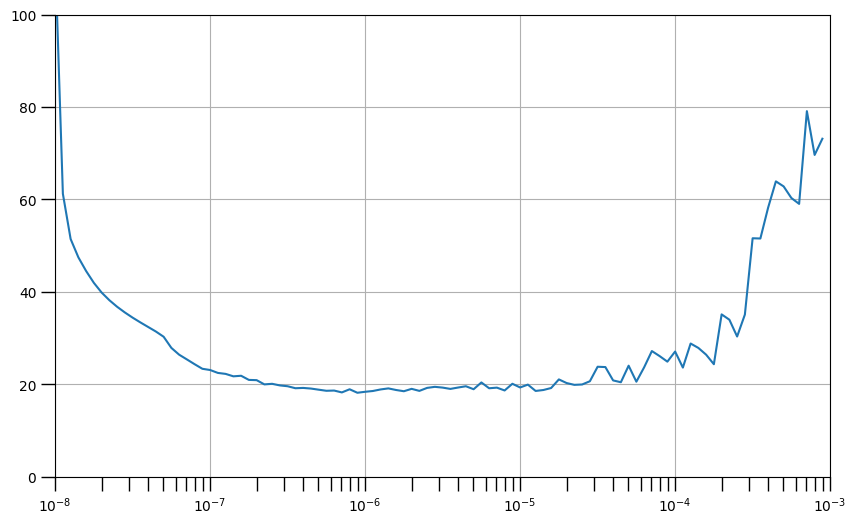

In [19]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params("both", length=10, width=1, which="both")

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

Now you can proceed to reset and train the model. It is set for 100 epochs in the cell below but feel free to increase it if you want. Laurence got his results in the lectures after 500.

In [20]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [21]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

In [22]:
# Train the model
history = model.fit(train_set, epochs=100, verbose=2)

Epoch 1/100


2022-12-02 11:07:56.896569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:07:57.088907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:07:57.158516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:07:57.272098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:07:57.376839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 - 3s - loss: 40.9889 - mae: 41.4859 - 3s/epoch - 37ms/step
Epoch 2/100
93/93 - 2s - loss: 23.4565 - mae: 23.9498 - 2s/epoch - 21ms/step
Epoch 3/100
93/93 - 2s - loss: 21.4981 - mae: 21.9912 - 2s/epoch - 21ms/step
Epoch 4/100
93/93 - 2s - loss: 20.6649 - mae: 21.1582 - 2s/epoch - 21ms/step
Epoch 5/100
93/93 - 2s - loss: 19.6434 - mae: 20.1364 - 2s/epoch - 21ms/step
Epoch 6/100
93/93 - 2s - loss: 18.9620 - mae: 19.4537 - 2s/epoch - 22ms/step
Epoch 7/100
93/93 - 2s - loss: 18.9121 - mae: 19.4038 - 2s/epoch - 25ms/step
Epoch 8/100
93/93 - 2s - loss: 19.0905 - mae: 19.5823 - 2s/epoch - 21ms/step
Epoch 9/100
93/93 - 2s - loss: 18.5868 - mae: 19.0789 - 2s/epoch - 20ms/step
Epoch 10/100
93/93 - 2s - loss: 18.1467 - mae: 18.6374 - 2s/epoch - 23ms/step
Epoch 11/100
93/93 - 2s - loss: 17.9550 - mae: 18.4464 - 2s/epoch - 23ms/step
Epoch 12/100
93/93 - 2s - loss: 18.1054 - mae: 18.5951 - 2s/epoch - 20ms/step
Epoch 13/100
93/93 - 2s - loss: 18.0530 - mae: 18.5427 - 2s/epoch - 20ms/step
Epoch 1

You can visualize the training and see if the loss and MAE are still trending down.

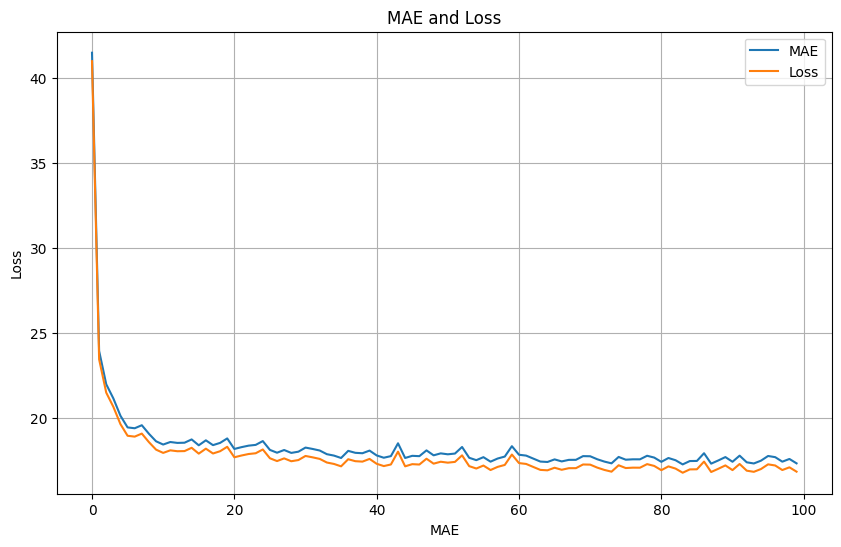

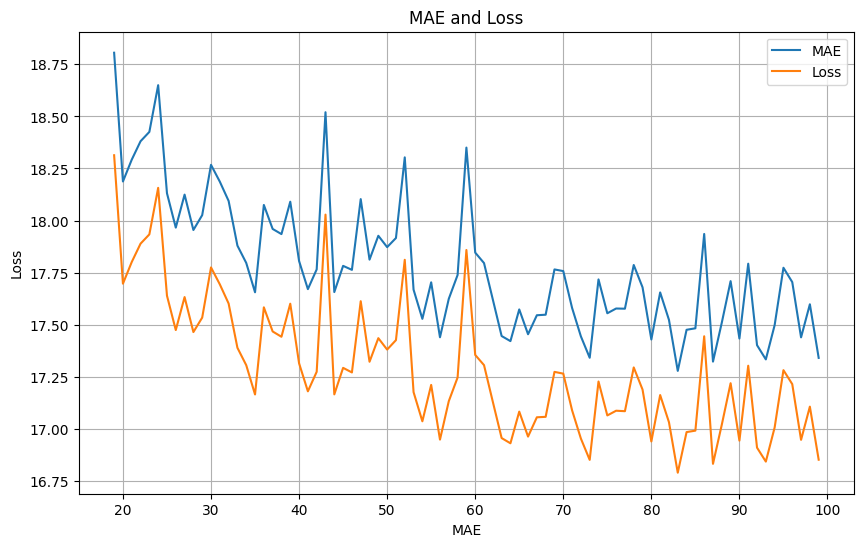

In [23]:
# Get mae and loss from history log
mae = history.history["mae"]
loss = history.history["loss"]

# Get number of epochs
epochs = range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title="MAE and Loss",
    xlabel="MAE",
    ylabel="Loss",
    legend=["MAE", "Loss"],
)

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title="MAE and Loss",
    xlabel="MAE",
    ylabel="Loss",
    legend=["MAE", "Loss"],
)

## Model Prediction

As before, you can get the predictions for the validation set time range and compute the metrics.

In [24]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

      1/Unknown - 0s 487ms/step

2022-12-02 11:12:00.580016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:12:00.636958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:12:00.702096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 63ms/step


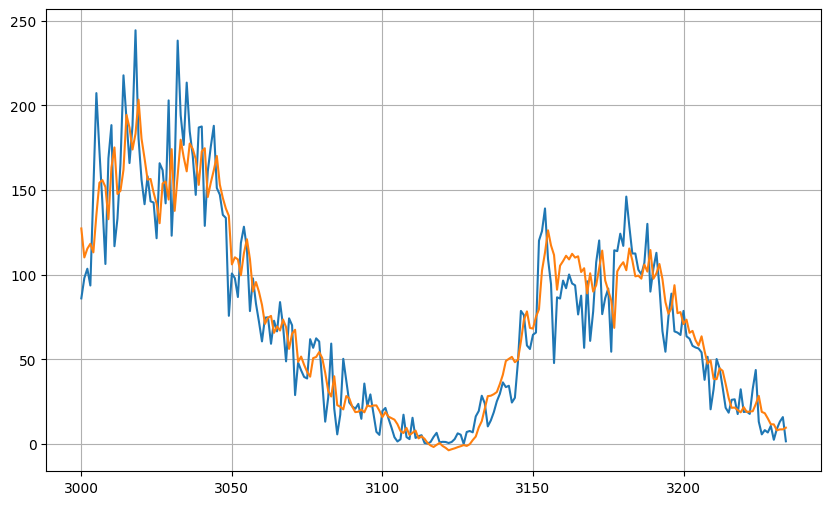

In [25]:
# Reduce the original series
forecast_series = series[split_time - window_size : -1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (y_valid, results))

In [26]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(y_valid, results).numpy())

15.041738


## Wrap Up

This concludes the final practice lab for this course! You implemented a deep and complex architecture composed of CNNs, RNNs, and DNNs. You'll be using the skills you developed throughout this course to complete the final assignment. Keep it up!

## Optional

In this optional section, you will look at another way to dynamically set the learning rate. As you may have noticed, training for a long time generates less and less changes to the loss and metrics. You can run the cell below to observe that again.

In [27]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

# Train the model
history = model.fit(train_set, epochs=10)

Epoch 1/10


2022-12-02 11:12:59.255281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:12:59.429052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:12:59.508819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:12:59.636917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      3/Unknown - 1s 29ms/step - loss: 17.8665 - mae: 18.3611

2022-12-02 11:12:59.738269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 4s 25ms/step - loss: 16.5341 - mae: 17.0236
Epoch 2/10
93/93 [==============================] - 2s 21ms/step - loss: 16.4774 - mae: 16.9670
Epoch 3/10
93/93 [==============================] - 2s 21ms/step - loss: 16.5030 - mae: 16.9936
Epoch 4/10
93/93 [==============================] - 2s 21ms/step - loss: 16.4656 - mae: 16.9556
Epoch 5/10
93/93 [==============================] - 2s 21ms/step - loss: 16.4627 - mae: 16.9532
Epoch 6/10
93/93 [==============================] - 2s 21ms/step - loss: 16.4751 - mae: 16.9644
Epoch 7/10
93/93 [==============================] - 2s 21ms/step - loss: 16.4533 - mae: 16.9445
Epoch 8/10
93/93 [==============================] - 2s 21ms/step - loss: 16.4477 - mae: 16.9369
Epoch 9/10
93/93 [==============================] - 2s 21ms/step - loss: 16.4488 - mae: 16.9385
Epoch 10/10
93/93 [==============================] - 2s 21ms/step - loss: 16.4344 - mae: 16.9248


At some point, the static learning rate you set might no longer be the optimal one when the model has been learning for some time. You may want to decrease it some more to see better improvements. One way to do that is to have your training loop gradually decay the learning rate per epoch. You can pass in a lambda function similar like the one you did for the learning rate scheduler earlier, or use [ExponentialDecay()](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay). This is a built in scheduler from the Keras API. This decays the learning rate defined by this function:

```
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)
```

See how it is used below.

In [28]:
# Set the initial learning rate
initial_learning_rate = 1e-7

# Define the scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=400, decay_rate=0.96, staircase=True
)

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

# Train the model
history = model.fit(train_set, epochs=40)

Epoch 1/40


2022-12-02 11:16:15.863551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:16:16.103976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:16:16.170229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:16:16.296195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      1/Unknown - 1s 1s/step - loss: 14.7372 - mae: 15.2229

2022-12-02 11:16:16.407838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 4s 26ms/step - loss: 16.4474 - mae: 16.9369
Epoch 2/40
93/93 [==============================] - 2s 21ms/step - loss: 16.4780 - mae: 16.9674
Epoch 3/40
93/93 [==============================] - 2s 21ms/step - loss: 16.4473 - mae: 16.9370
Epoch 4/40
93/93 [==============================] - 2s 21ms/step - loss: 16.4537 - mae: 16.9433
Epoch 5/40
93/93 [==============================] - 2s 21ms/step - loss: 16.4178 - mae: 16.9082
Epoch 6/40
93/93 [==============================] - 2s 21ms/step - loss: 16.4431 - mae: 16.9330
Epoch 7/40
93/93 [==============================] - 2s 22ms/step - loss: 16.4347 - mae: 16.9243
Epoch 8/40
93/93 [==============================] - 2s 21ms/step - loss: 16.4461 - mae: 16.9360
Epoch 9/40
93/93 [==============================] - 2s 21ms/step - loss: 16.4153 - mae: 16.9057
Epoch 10/40
93/93 [==============================] - 2s 21ms/step - loss: 16.4184 - mae: 16.9081
Epoch 11/40
93/93 [==============================]

Now see the results by geting predicitons and computing the metrics.

2022-12-02 11:18:52.656886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:18:52.720293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:18:52.799067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 27ms/step


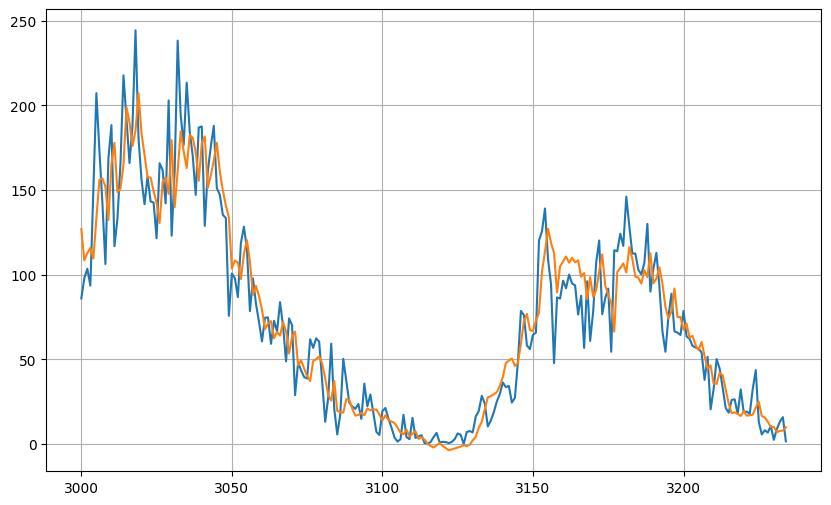

In [29]:
# Reduce the original series
forecast_series = series[split_time - window_size : -1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (y_valid, results))

In [30]:
# Compute the MAE
tf.keras.metrics.mean_absolute_error(y_valid, results).numpy()

14.840147